# Laboratorio 1

**Andres Chaparro - 202111146** 

**Juan Esteban Lopez Ulloa - 202021417**

**Juan Diego Lozano Guerrero - 202122869**



#

In [128]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

# 1. Carga de datos (csv)
Se cargan la base de datos (CSV) para trabajar con estos

In [129]:
# Cargar los datos de los archivos CSV
direccionValidation = 'validation_data.csv'
direccionTrain = 'train_data.csv'
validation_data = pd.read_csv(direccionValidation)
train_data_original = pd.read_csv(direccionTrain)

print(validation_data.shape)
print(train_data_original.shape)

(1000, 17)
(4000, 18)


In [130]:
validation_data.head()

,ra,colv,i,rowv,class,dec,score,camcol,field,clean,r,z,g,run,objid,u,mjd
0,190.129408,0.000187,17.04507,0.000731,STAR,0.740488,0.822898,5,496,1,17.23757,16.98653,17.72796,756,1237648722308890798,18.84865,54567
1,126.739160,-0.001844,17.87246,-0.000979,STAR,-0.982894,0.868712,1,73,1,17.96179,17.83893,18.27308,756,1237648720133685722,19.34957,53083
2,162.692083,-0.004810,16.20404,-0.004358,GALAXY,1.068587,0.830950,6,313,0,16.55942,15.94029,17.21567,756,1237648722833768573,18.64485,51909
3,190.181702,-0.012342,17.48020,-0.002584,GALAXY,0.797830,0.833386,5,497,0,17.69294,17.30092,18.12268,756,1237648722308956300,19.25978,51941
4,225.414989,-0.000250,17.81908,-0.000397,STAR,0.878768,0.881142,6,547,1,17.89974,17.79936,18.12826,752,1237648705669234734,19.39298,51990


In [131]:
train_data_original.head()

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,class,redshift,mjd,rowv,colv
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,STAR,8.780529e-05,54140,0.002418,0.001363
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,GALAXY,8.619995e-02,51955,0.008650,0.007056
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,GALAXY,1.330486e-01,51913,0.003938,-0.002028
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,GALAXY,8.636355e-02,51959,0.001839,0.001160
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,STAR,-4.090000e-08,54562,0.001929,-0.000465


# 2. Entendimientos de los datos

El análisis realizado muestra que no hay valores nulos en ninguna de las columnas del DataFrame validation_data. Esto es evidente ya que la proporción de valores nulos para todas las columnas (ra, colv, i, rowv, class, dec, score, camcol, field, clean, r, z, g, run, objid, u, mjd) es igual a 0.

In [132]:
features = ["objid", "ra", "dec", "u", "g", "r", "i", "z", "run", "camcol", "field", "score", "clean", "class", "redshift", "mjd", "rowv", "colv"]
train_data = train_data_original.copy()
train_data[features].isnull().sum() / train_data.shape[0]


objid       0.0
ra          0.0
dec         0.0
u           0.0
g           0.0
r           0.0
i           0.0
z           0.0
run         0.0
camcol      0.0
field       0.0
score       0.0
clean       0.0
class       0.0
redshift    0.0
mjd         0.0
rowv        0.0
colv        0.0
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

#### Relaciones entre las Magnitudes con la variable objetivo Redshift
Se puede observar que las magnitudes se distribuyen de forma aleatoria respecto al redshift y todas tienen una distribución algo similar pero esto se puede deber a datos atipicos que pueden estar afectando como se pueden notar hay datos que estan muy por encima de los demas, lo que puede indicar presencia de outliers

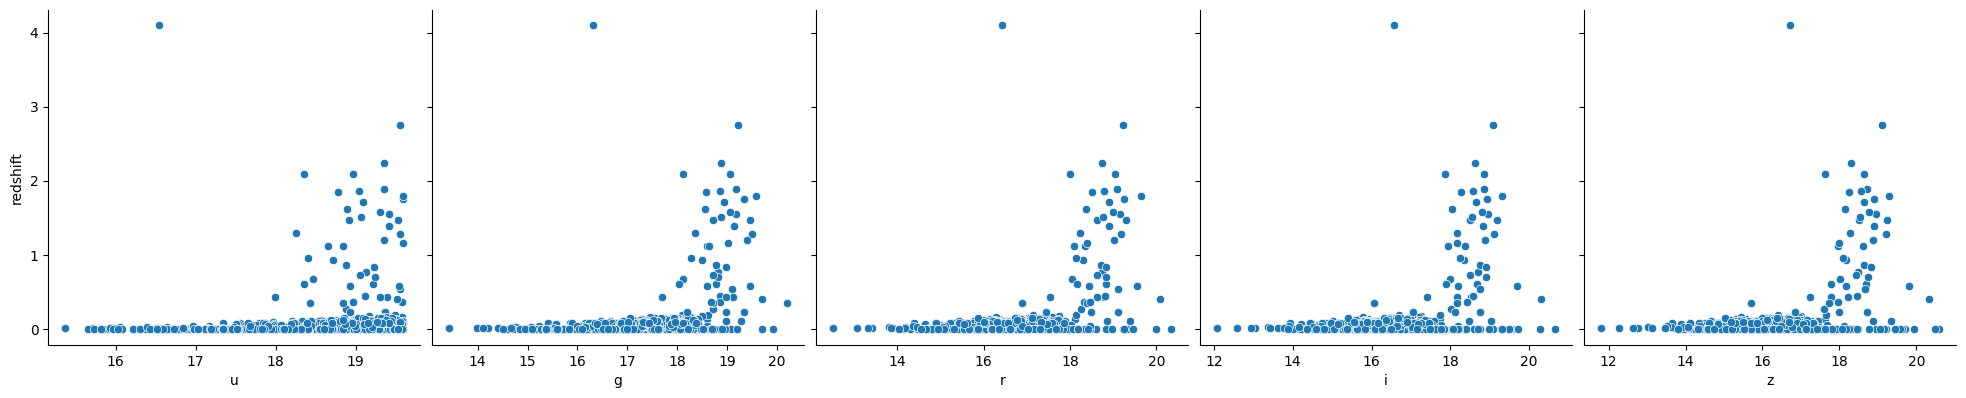

In [133]:

magnitude_features = ["u", "g", "r", "i", "z"]
sns.pairplot(train_data.sample(frac=0.2), height=4, y_vars="redshift", x_vars=magnitude_features, kind="scatter")


#### Relaciones de otros atributos como la ubicación, velocidad y valor de calidad con el valor objetivo Redshift

En este caso se puede observar como la ubicación en ascenso y declinacion tiene una distribucion aleatoria pero con algunos valores atipicos que salen del rango comun de los datos, lo que se puede observar mas en la ubicacion de declinación.  Por otro lado en las velocidades se puede observar también una distribucion similar en ambas donde se centran los datos en cero. Por ultimo, en el valor de calidad de la observación se puede observar tambien una distribución aleatoria donde normalmente se tiene una gran calidad de las fotos, pero hay otra pequeña cantidad de datos que obtuvieron baja calidad de datos.

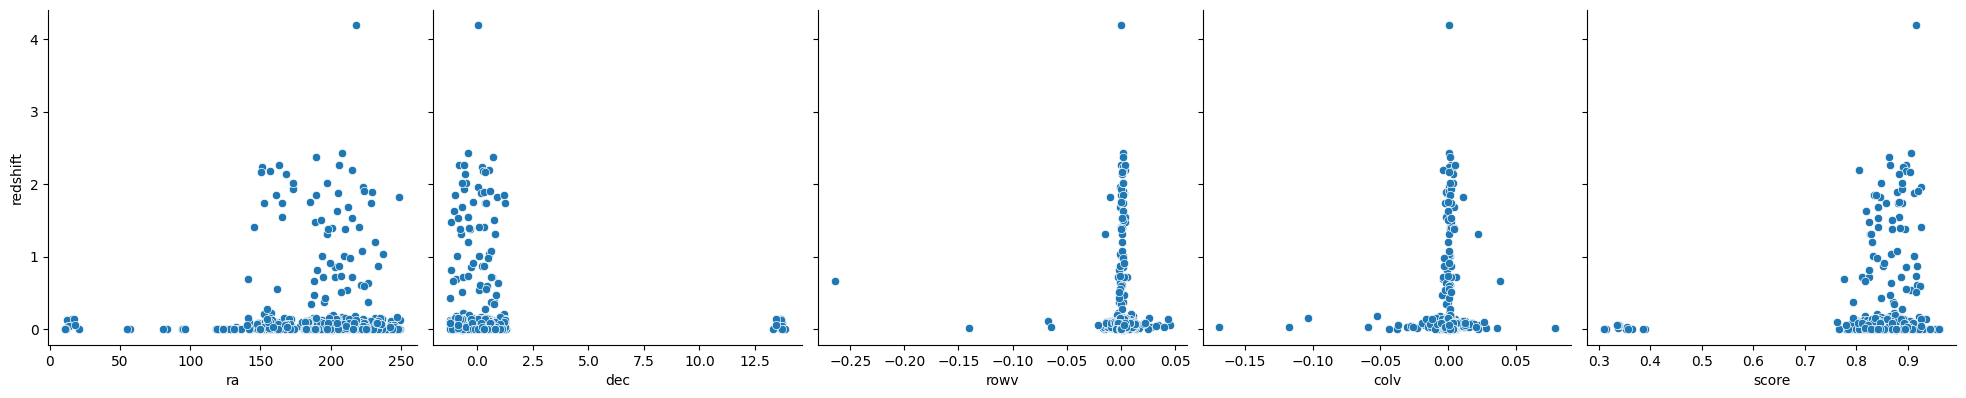

In [134]:
features = ["ra", "dec", "rowv", "colv", "score"]
sns.pairplot(train_data.sample(frac=0.2), height=4, y_vars="redshift", x_vars=features, kind="scatter")



#### Relaciones de otros atributos como el numero de observación, sección y dia juliano con el valor objetivo Redshift

Se puede observar como el numero de observación realizada por el telescopio tiene valores muy cercanos a un valores exceptuando por algunos valores que toman valores extremos, para el caso de la seccion de la columna field y camcol se puede observar una distribucion aleatoria 

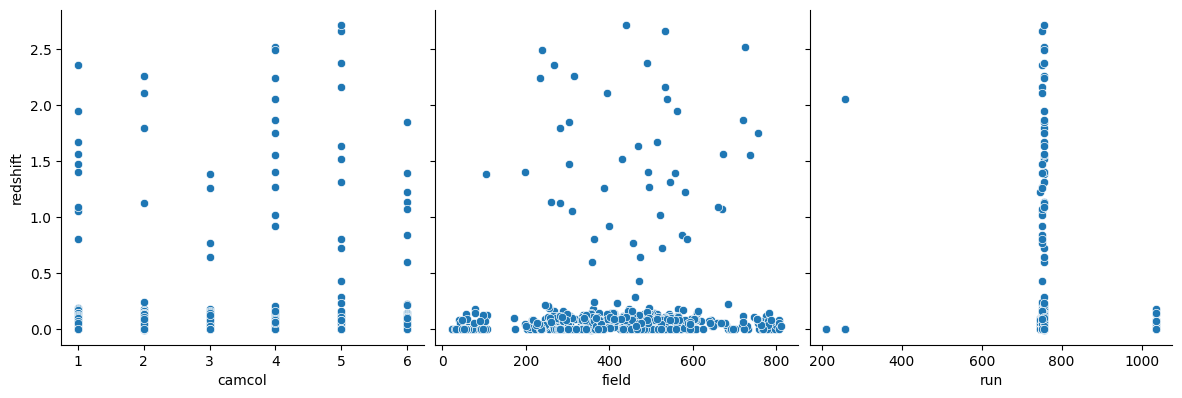

In [135]:
features = ["camcol", "field", "run"]
sns.pairplot(train_data.sample(frac=0.2), height=4, y_vars="redshift", x_vars=features, kind="scatter")


#### Relaciones de otros atributos categoricos con el valor objetivo Redshift

En los BoxPlots de abajo se observan las diferentes columnas categoricas que hay en la base de datos, para el caso de la clase del tipo registrado se deberian tener solamente Estrella (STAR) o Galaxia (GALAXY) o Cuasar (QSO) pero se puede observar que hay otras clases no identificadas como S, QUASAR y Q lo que puede indicar errores en estos datos. Para los otros datos categoricos si se ven relaciones aleatorias sin alteraciones o probables errores.


C:\Users\andre\AppData\Local\Temp\ipykernel_11884\1093796258.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train_data, x="class", y="redshift", palette="Set2")


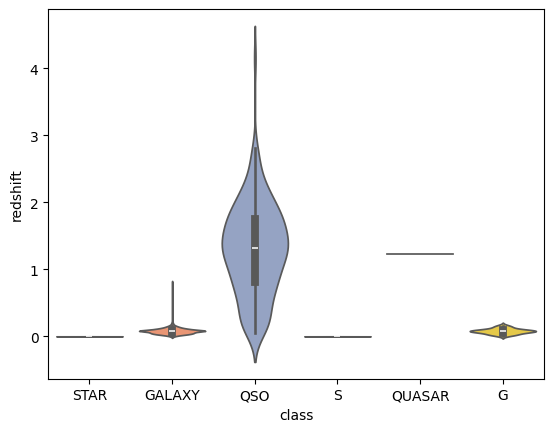

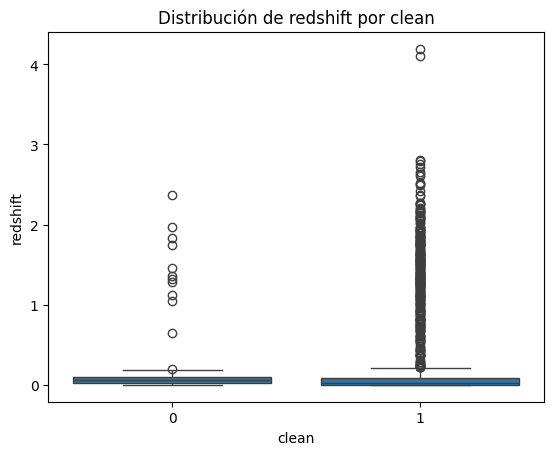

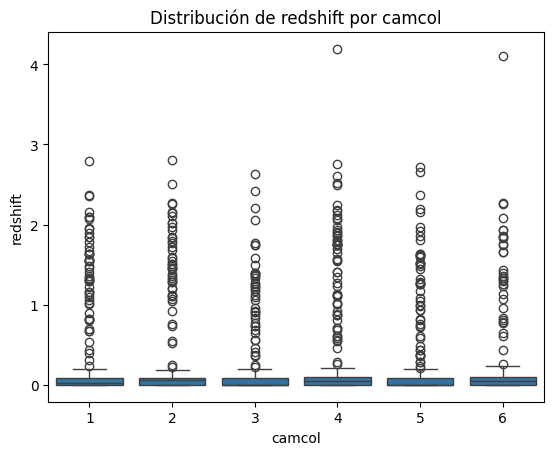

In [136]:
# Distribución de redshift por clase de objeto (class)
sns.violinplot(data=train_data, x="class", y="redshift", palette="Set2")
plt.show()

# Boxplot para cada característica categórica individualmente
for feature in ["clean", "camcol"]:
    
    sns.boxplot(data=train_data, x=feature, y="redshift")
    plt.title(f"Distribución de redshift por {feature}")
    plt.show()


### 2.2. Búsqueda de relaciones entre las variables de entrada


En la grafica de abajo se grafica las correlaciones entre las diferentes variables numericas, como se puede observar hay poca correlacion entre las diferentes variables exceptuando en las magnitudes donde estas tienen correlaciones altas que pueden variar desde 0,5 a 0,8 de correlacion entre estas

<Axes: >

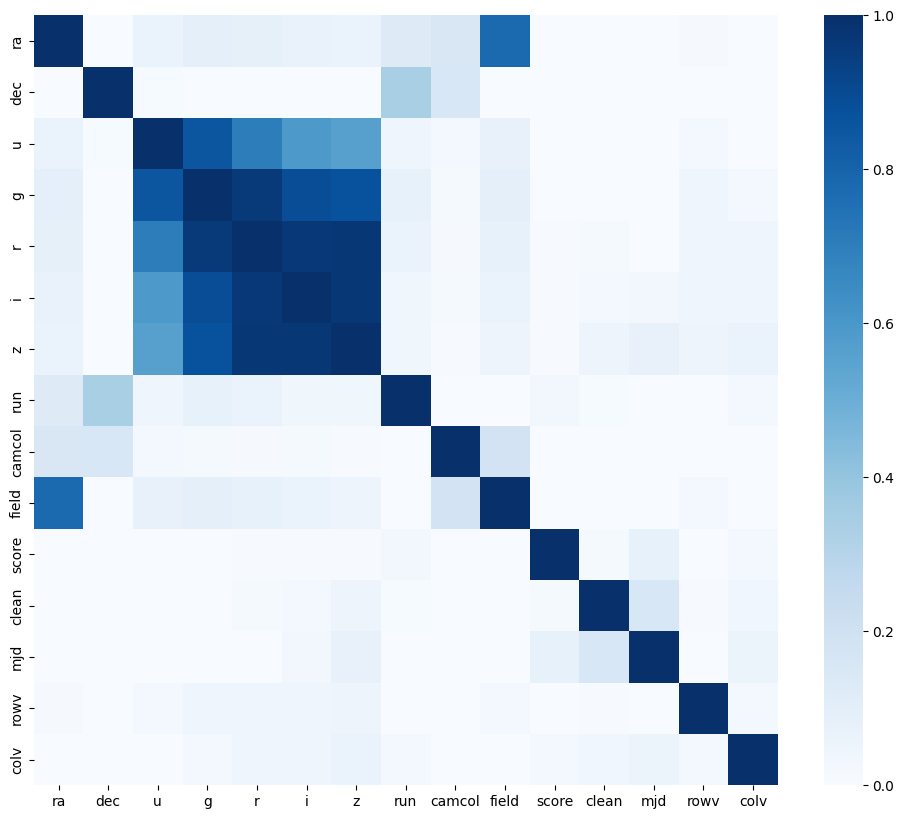

In [137]:
features = [ "ra", "dec", "u", "g", "r", "i", "z", "run", "camcol", "field", "score", "clean", "mjd", "rowv", "colv"]
plt.figure(figsize=(12, 10))
sns.heatmap(train_data[features].corr(), cmap="Blues", vmin=0, vmax=1)

### 2.3 Distribuciones individuales de las características

Aca se puede observar que la mayoria de magnitudes tienden a formar un histograma con distribucion normal exceptuando al magnitud de ultravioleta, en cuanto a las ubicaciones muestran una distribucion mas aleatoria, en cuanto al score de calidad tambien presenta una distribucion normal pero con valores extremos, por ultimo, las velocidades y redshift presentan una distribucion con menor variacion en sus datos centrandose en unos valores especificos.

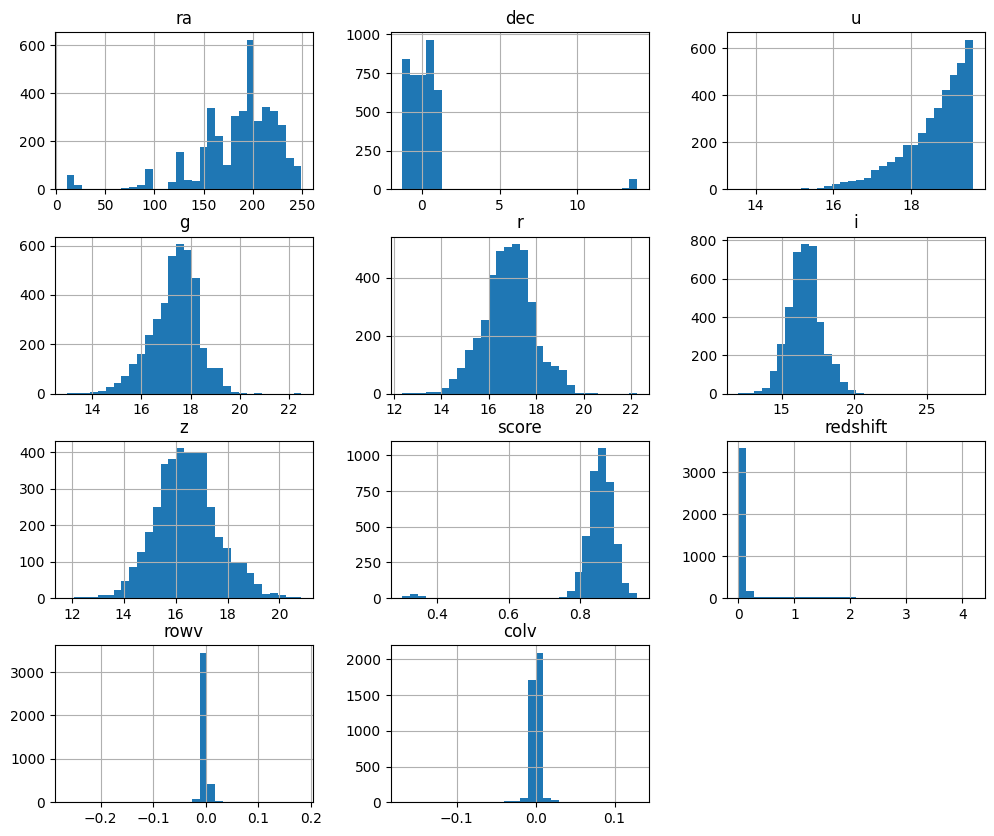

In [138]:

features = ["ra", "dec", "u", "g", "r", "i", "z", "score", "redshift", "rowv", "colv"]
train_data[features].hist(figsize=(12, 10), bins=30)
plt.show()


## 3. Selección de variables

In [139]:
# Train data
train_data2 = train_data.copy() 

# Funcion para eliminar las variables no seleccioandas
def seleccion_de_variables(data, variable):
    return data.drop(columns=[variable])  

<Axes: >

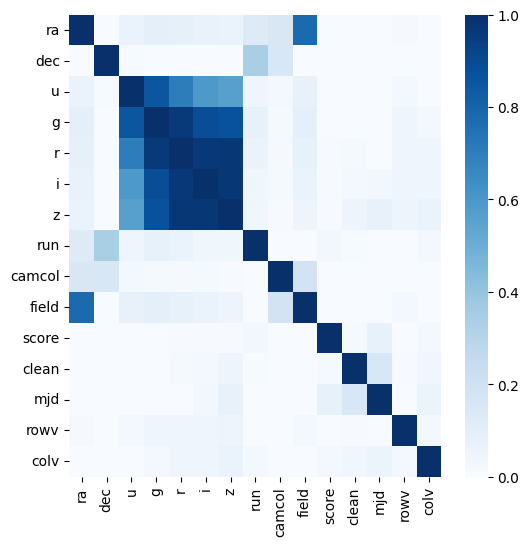

In [140]:
features = [ "ra", "dec", "u", "g", "r", "i", "z", "run", "camcol", "field", "score", "clean", "mjd", "rowv", "colv"]
plt.figure(figsize=(6, 6))
sns.heatmap(train_data2[features].corr(), cmap="Blues", vmin=0, vmax=1)

Teniendo en cuenta el mapa de correlación se empezarán a eliminar variables que tengan la correlación superior a 0.8 como se menciona en el laboratorio de "Machine learning supervisado, regresión". Inicialmente se eliminará la la variable "z" que corresponde a casi-infrarojo, se espera que con la variable "i" la cual corresponde a infrarojo baste para utilizar bien el modelo.

In [141]:
#Eliminar la columba z
train_data_filtrada_1 = seleccion_de_variables(train_data2, "z")

<Axes: >

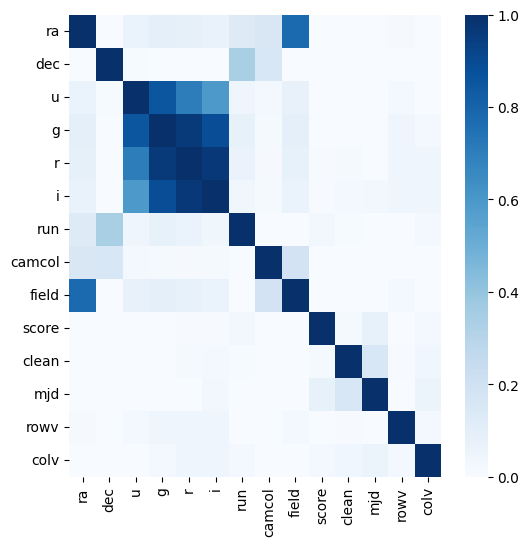

In [142]:
features = [ "ra", "dec", "u", "g", "r", "i", "run", "camcol", "field", "score", "clean", "mjd", "rowv", "colv"]
plt.figure(figsize=(6, 6))
sns.heatmap(train_data_filtrada_1[features].corr(), cmap="Blues", vmin=0, vmax=1)

Ahora bien, ya eliminando la variable "z" se vuelve a realizar el analisis de las correlaciones en el cual se puede ver que siguen existiendo relaciones mayores a 0.8. En este orden de ideas, se eliminará la variable del filtro verde (g) para seguir evitando información redundante en las variables.

In [143]:
#Eliminar la columba g
train_data_filtrada_2 = seleccion_de_variables(train_data_filtrada_1, "g")

<Axes: >

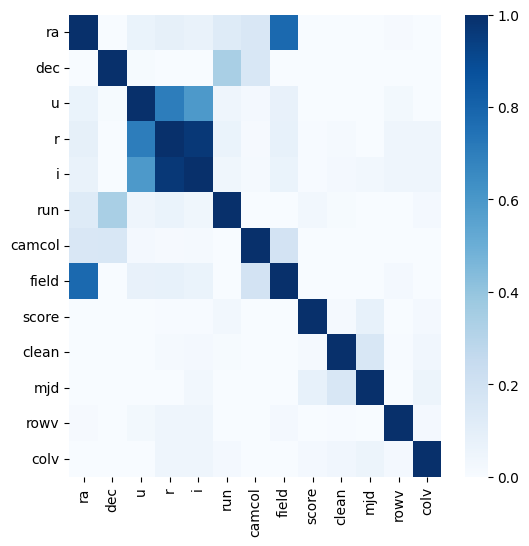

In [144]:
features = [ "ra", "dec", "u", "r", "i", "run", "camcol", "field", "score", "clean", "mjd", "rowv", "colv"]
plt.figure(figsize=(6, 6))
sns.heatmap(train_data_filtrada_2[features].corr(), cmap="Blues", vmin=0, vmax=1)

Finalmente se eliminará la variable "r" la cual corresponde al filtro rojo ya que se cuenta con la variable de filtro infrarojo(i) la cual como se puede ver en el grafico de correlación se podría tener inforamción redundante.

In [145]:
#Eliminar la columba r
train_data_filtrada_3 = seleccion_de_variables(train_data_filtrada_2, "r")

<Axes: >

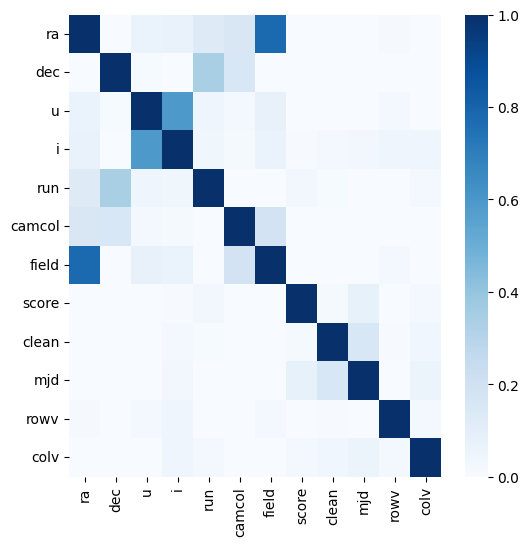

In [146]:
features = [ "ra", "dec", "u", "i", "run", "camcol", "field", "score", "clean", "mjd", "rowv", "colv"]
plt.figure(figsize=(6, 6))
sns.heatmap(train_data_filtrada_2[features].corr(), cmap="Blues", vmin=0, vmax=1)

Adicionalmente se dicidio eliminar las columnas objid y runs ya que es información que creemos no aporta valor. Mientras que al quitar estas columnas disminuimos el tamaño de los datos.

In [147]:
#Eliminar la columba runs y objid
train_data_filtrada_4 = seleccion_de_variables(train_data_filtrada_3, "run")
train_data_filtrada_5 = seleccion_de_variables(train_data_filtrada_4, "objid")

In [148]:
print(train_data_filtrada_5.head())

           ra       dec         u         i  camcol  field     score  clean  \
0  185.574486  0.701402  19.11034  16.82993       5    466  0.864145      1   
1  203.801841 -0.853906  18.90957  16.62059       1    588  0.816541      1   
2  160.034264 -0.421626  19.26340  16.42307       2    295  0.870381      1   
3  200.807373 -0.682024  18.82022  17.11128       2    382  0.867801      1   
4  189.792404 -1.001480  18.91391  19.75660       1    494  0.833824      1   

    class      redshift    mjd      rowv      colv  
0    STAR  8.780529e-05  54140  0.002418  0.001363  
1  GALAXY  8.619995e-02  51955  0.008650  0.007056  
2  GALAXY  1.330486e-01  51913  0.003938 -0.002028  
3  GALAXY  8.636355e-02  51959  0.001839  0.001160  
4    STAR -4.090000e-08  54562  0.001929 -0.000465  


## 4. Preparación y limpieza de datos

In [149]:
features = train_data_filtrada_5.columns

train_data_prep = train_data_filtrada_5.copy()

In [150]:
# Reviasr si hay valores nulos
print(train_data_prep.isnull().sum())

ra          0
dec         0
u           0
i           0
camcol      0
field       0
score       0
clean       0
class       0
redshift    0
mjd         0
rowv        0
colv        0
dtype: int64


In [151]:
# Reivsar si hay duplicados
duplicated_rows_xy = train_data_prep.loc[train_data_prep.duplicated(keep=False)].shape[0]
print(duplicated_rows_xy)

duplicated_rows_x = train_data_prep.loc[train_data_prep.duplicated(subset=features, keep=False)].shape[0]
print(duplicated_rows_x)

34
34


Como el numero de duplicados es el mismo incluyendo o no la variable de respuesta (redshift) entonces lo unico que se debe hacer es eliminar estos valores.

In [152]:
train_data_prep_1 = train_data_prep.drop_duplicates(keep='first')
train_data_prep_1.shape

(3983, 13)

In [153]:
# Verificar problemas consistencia y validez
# u, i mayores a 0
print(train_data_prep_1[train_data_prep_1["u"] < 0].shape[0])
# scores valores entre 0 y 1
print(train_data_prep_1[train_data_prep_1["score"] < 0].shape[0])
print(train_data_prep_1[train_data_prep_1["score"] > 1].shape[0])
# clean es o 0 o 1
dif_0 = train_data_prep_1[train_data_prep_1["clean"] != 0].shape[0]
dif_1 = train_data_prep_1[train_data_prep_1["clean"] != 1].shape[0]
print(dif_0 + dif_1 - train_data_prep_1.shape[0])

0
0
0
0


Dada la información en el diccionario de datos se verificó que los datos fueran coherentes. Efectivamente no hay datos que no sean coherentes con la definicion dada. También se verifico la validez de los datos al asegurar que se cumplieran los rangos de los valores.

Antes de volver la caracteristica "class" en una variable dummy, primero se debe corregir el problema de inconsistencia ya que en el diccionario mencionan solo 3 tipos de clase y en los datos hay 2 extra que son S y G. En este caso asumiremos que los datos con el valor S pertenecen a la categoria STAR y el valor G a la categoria GALAXY

In [154]:
def clean_class(data):
    return data.loc[data["class"].isin(["STAR", "GALAXY", "QSO"])]

# Los registros con S se replaza por STAR, los que tienen G con GALAXY y los que tienen QUASAR con QSO

train_data_prep_2 = clean_class(train_data_prep_1)
print(train_data_prep_2["class"].value_counts())

class
GALAXY    1847
STAR      1625
QSO        291
Name: count, dtype: int64


Con el perfilamiento de los datos se pudo ver que las caracteristicas "class" y "clean" son varibales categoricas. Como el model que se utilizará es regresion lineal, se necestia que todos los valores sean numericos. En el caso de "clean", si bien es categorica, es una variable dummie, por lo que ya se encuentra en numeros (0 y 1) pero los valores de la variable "class" si son categorias por lo que se debe transformar esta variable.

In [155]:
# Separar las categorias de la columna class en diferentes columnas y si pertenece a la categoria se pone un 1 y si no un 0
def one_hot_encode(data, column):
    return pd.get_dummies(data, columns=[column], prefix=column, drop_first=True)

datos_limpios = one_hot_encode(train_data_prep_2, "class")
datos_limpios.head()

,ra,dec,u,i,camcol,field,score,clean,redshift,mjd,rowv,colv,class_QSO,class_STAR
0,185.574486,0.701402,19.11034,16.82993,5,466,0.864145,1,8.780529e-05,54140,0.002418,0.001363,False,True
1,203.801841,-0.853906,18.90957,16.62059,1,588,0.816541,1,8.619995e-02,51955,0.008650,0.007056,False,False
2,160.034264,-0.421626,19.26340,16.42307,2,295,0.870381,1,1.330486e-01,51913,0.003938,-0.002028,False,False
3,200.807373,-0.682024,18.82022,17.11128,2,382,0.867801,1,8.636355e-02,51959,0.001839,0.001160,False,False
4,189.792404,-1.001480,18.91391,19.75660,1,494,0.833824,1,-4.090000e-08,54562,0.001929,-0.000465,False,True


## 5. Construcción del modelo de regresión lineal y cálculo de sus métricas de calidad
### Partición de datos
Lo primero que se hace es dividir en los que seran utilizados para entrenar y despues para testear ademas de dividir los datos para entrenar al modelo como las variables de entrada y las de salida

In [156]:
features = datos_limpios.columns.drop("redshift")  # Selecciona todas las columnas excepto "redshift"
X_train, X_test, y_train, y_test = train_test_split(datos_limpios[features], datos_limpios["redshift"], test_size=0.15, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3198, 13), (565, 13), (3198,), (565,))

Se crea ahora el modelo de regresión lineal 

In [157]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

### Interpretación de los coeficientes y del intercepto


### 5.1. Interpretación de los coeficientes y del intercepto


El modelo de regresión lineal utiliza el valor de corrimiento al rojo (redshift) como variable dependiente y evalúa múltiples predictores astronómicos y fotométricos. Las estadísticas del valor objetivo muestran que tiene un promedio de 0.133 con un rango que va desde valores cercanos a cero hasta 4.19, y presenta una alta concentración de datos en los cuartiles inferiores, reflejando su asimetría. 

In [158]:
y_train.describe()

count    3198.000000
mean        0.140711
std         0.386654
min        -0.003322
25%         0.000124
50%         0.037507
75%         0.088185
max         4.099630
Name: redshift, dtype: float64

En cuanto a los coeficientes de la regresión, variables como la velocidad horizontal (*rowv*) y la velocidad vertical (*colv*) tienen un impacto considerable, siendo *rowv* negativa y *colv* positiva, lo que sugiere que mayores velocidades en estas direcciones pueden influir significativamente en el corrimiento al rojo. Las magnitudes fotométricas como *u* e *i* presentan efectos positivos, especialmente *i*, lo que implica que los objetos más brillantes en el infrarrojo tienden a tener mayores valores de *redshift*. El indicador *clean* también tiene un impacto positivo moderado, indicando que la confiabilidad en la fotometría está asociada con un mayor *redshift*. Por otro lado, las variables categóricas muestran que los quásares (*class_QSO*) contribuyen fuertemente al corrimiento al rojo, mientras que las estrellas (*class_STAR*) tienen un efecto opuesto. Finalmente, variables como *ra*, *dec*, y *field* tienen impactos muy pequeños, sugiriendo que no aportan un cambio significativo al valor de *redshift*. Esto evidencia que la combinación de características dinámicas (como velocidades) y fotométricas son los principales predictores del corrimiento al rojo en el modelo. En cuanto al intercepto del modelo es -1.2148, lo que representa el valor promedio del redshift cuando todas las variables predictoras se encuentran en cero. Aunque este valor no tiene una interpretación física directa, ya que varias variables como u, i, y score no pueden ser cero, sugiere que en ausencia de contribuciones de las variables predictoras, el modelo estima un valor base de corrimiento al rojo negativo. Esto evidencia que la combinación de características dinámicas (como velocidades) y fotométricas son los principales predictores del corrimiento al rojo en el modelo. 

In [159]:
print("El intercepto es:", regression.intercept_)
pd.DataFrame({"columns": features, "coef": regression.coef_})

El intercepto es: -1.399898444143


,columns,coef
0,ra,-0.000141
1,dec,-0.001373
2,u,0.001355
3,i,0.019692
4,camcol,-0.000349
5,field,0.000030
6,score,-0.041909
7,clean,0.009904
8,mjd,0.000023
9,rowv,-0.552342


In [ ]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 5.2 Validación y metricas de calidad del modelo

La forma más básica para saber que tan bien se comporta el modelo es midiendo que tanto se alejan las estimaciones o predicciones del mismo respecto a la variable objetivo real. Esta medición se puede hacer tanto para el conjunto de datos de entrenamiento como para el de prueba.
**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

Como se puede observar las métrica de error MAE para el dataset de entrenamiento y prueba son muy similares. No se evidencian problemas de sobreajuste (overfitting).

In [ ]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 0.07129761487027028
Test: 0.06980697547447767


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

Como se puede observar las métrica de error RMSE para el dataset de entrenamiento y prueba son muy similares. No se evidencian problemas de sobreajuste (overfitting).

In [ ]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.18670140509337332
Test: 0.20653412983328476


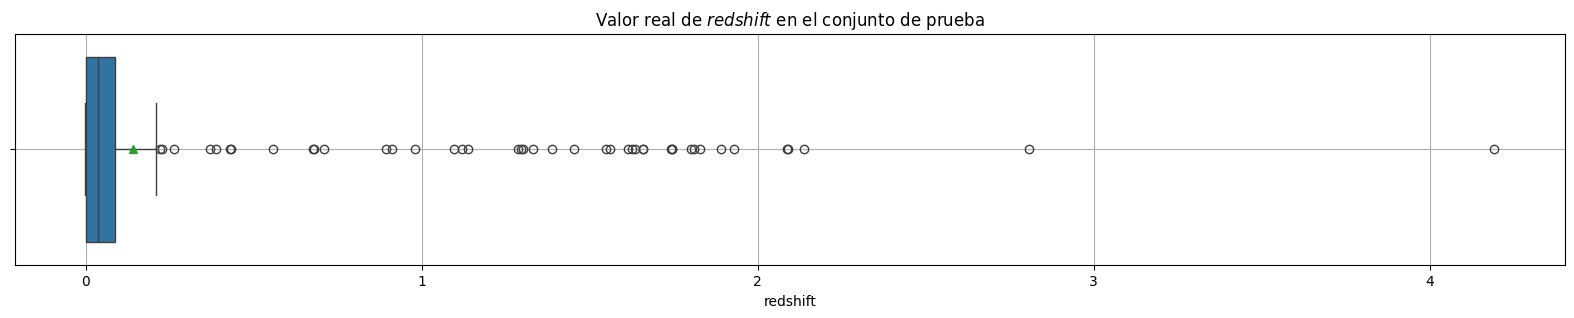

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{redshift}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [ ]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    565.000000
mean       0.141855
std        0.407866
min       -0.000859
25%        0.000106
50%        0.035455
75%        0.087792
99%        1.904822
max        4.192597
Name: redshift, dtype: float64

Como se puede observar en el box plot y en las estadisticas del redshift donde la media (0.1418) es notablemente mayor que la mediana (0.0354), lo que indica que la distribución es asimétrica y presenta una cola a la derecha (algunos valores muy altos que elevan la media).
La mayoría de los valores (hasta el 75%) se concentran en rangos muy bajos (inferiores a 0.09), mientras que existen valores extremos que elevan el percentil 99 y el máximo.

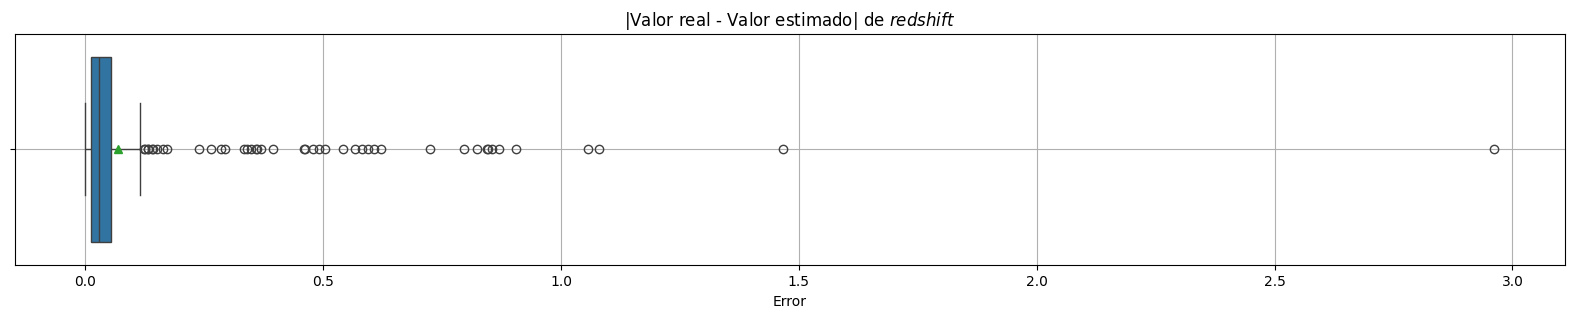

In [ ]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=abs(y_test - regression.predict(X_test)), showmeans=True, orient="h")
plt.title("|Valor real - Valor estimado| de $\t{redshift}$")
plt.xlabel("Error")
plt.grid()
plt.show()

In [ ]:
abs(y_test-regression.predict(X_test)).describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    565.000000
mean       0.069807
std        0.194552
min        0.000092
25%        0.011455
50%        0.028060
75%        0.053538
95%        0.338989
99%        0.860021
max        2.962079
Name: redshift, dtype: float64

La media de las predicciones (0.069) es aproximadamente la mitad de la media de los valores reales (0.14). La desviación estándar es menor (0.194 frente a 0.40), lo que indica que las predicciones están más concentradas en torno a su media y no capturan adecuadamente la dispersión real de los datos.
Los percentiles altos (por ejemplo, 95% y 99%) de las predicciones son mucho menores que los correspondientes en los datos reales, lo que sugiere que el modelo tiende a subestimar los valores elevados de redshift.

**Analisis de las metricas**

Aunque las métricas globales (MAE y RMSE) sugieren que el modelo de regresión lineal está funcionando de manera consistente en entrenamiento y prueba, el análisis de la distribución revela un sesgo importante: el modelo tiende a subestimar el redshift, especialmente en los valores elevados. Esto indica que, pese a un rendimiento aceptable en términos de error medio, existen áreas de mejora en cuanto a la captura de la variabilidad completa de la variable objetivo.

In [ ]:
percentile_95 = y_test.quantile(0.95)
print(f"Percentil 95 de y_test: {percentile_95}")
# Filtrar los valores de redshift mayores a 1 en el conjunto de prueba
y_test_filtered = y_test[y_test > percentile_95]
X_test_filtered = X_test.loc[y_test_filtered.index]

# Calcular el error absoluto de los valores de redshift del test y los obtenidos por el modelo de regresión
errors = abs(y_test_filtered - regression.predict(X_test_filtered))

# Mostrar los errores
print(errors.describe())


Percentil 95 de y_test: 1.0734174199999946
count    29.000000
mean      0.490646
std       0.568350
min       0.001304
25%       0.171268
50%       0.358496
75%       0.540941
max       2.962079
Name: redshift, dtype: float64


In [ ]:
percentile_95 = y_test.quantile(0.95)
print(f"Percentil 95 de y_test: {percentile_95}")
# Filtrar los valores de redshift mayores a 1 en el conjunto de prueba
y_test_filtered = y_test[y_test < percentile_95]
X_test_filtered = X_test.loc[y_test_filtered.index]

# Calcular el error absoluto de los valores de redshift del test y los obtenidos por el modelo de regresión
errors = abs(y_test_filtered - regression.predict(X_test_filtered))

# Mostrar los errores
print(errors.describe())


Percentil 95 de y_test: 1.0734174199999946
count    536.000000
mean       0.047038
std        0.113476
min        0.000092
25%        0.010547
50%        0.026549
75%        0.046914
max        1.079897
Name: redshift, dtype: float64


### 5.3 Análisis de los errores absolutos del modelo
El análisis de los errores absolutos del modelo muestra que este tiene mayores dificultades para predecir correctamente los valores de *redshift* altos (por encima del percentil 95, es decir, alrededor de 1) en comparación con los valores más bajos. Para los valores mayores al percentil 95, el error promedio del modelo es de 0.49, con una desviación estándar de 0.56, alcanzando un máximo de 2.96. Esto contrasta significativamente con los errores de los valores por debajo del percentil 95, donde el error promedio es de solo 0.047, con una desviación estándar mucho menor de 0.11 y un máximo de 1.079. Esto evidencia que el modelo de regresión lineal es menos efectivo para capturar patrones asociados a valores de *redshift* más extremos, probablemente debido a que estos valores son menos frecuentes en los datos de entrenamiento, lo que limita su capacidad para generalizar en estos casos. Por lo tanto, sería recomendable explorar modelos más complejos o incluir características adicionales que puedan capturar mejor los comportamientos de los valores altos de *redshift*.

## 6. Implementación del pipeline con todas las transformaciones requeridas para la generación de predicciones, exportado en formato .joblib

Primero se crean las funciones que se van a utilizar para hacer la transformación de los datos

In [ ]:
PosicionColumnas = X_train.columns
def FiltrarDatos(data):
    # 1. Eliminar las columnas no seleccionadas
    data1 = data.drop(columns=["z", "g", "r", "run", "objid"], errors="ignore")
    
    # 2. Filtrar las filas para conservar solo las categorías deseadas en 'class'
    data2 = data1.loc[data1["class"].isin(["STAR", "GALAXY", "QSO"])]
    
    # 3. Convertir la columna 'class' en variables dummy (columnas binarias)
    data3 = pd.get_dummies(data2, columns=["class"], prefix="class", drop_first=True)
    
    # 4. Reordenar las columnas de data3 para que tengan el mismo orden que PosicionColumnas.
    # Si alguna columna de PosicionColumnas no está en data3, se agregará con valor 0.
    data4 = data3.reindex(columns=PosicionColumnas, fill_value=0)
    
    return data4


prueba = FiltrarDatos(validation_data)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
import joblib

# Crear el transformador para FiltrarDatos
filtrar_transformer = FunctionTransformer(FiltrarDatos)

# Crear el pipeline con la función personalizada
pipeline = Pipeline(
    [
        ("filtrar", filtrar_transformer),  # Paso para filtrar los datos
        ("scaler", StandardScaler()),     # Escalar las características
        ("model", LinearRegression())     # Modelo de regresión lineal
    ]
)


Esta vez se van a volver a dividir los datos de la base de datos pero esta vez se van a usar los datos limpios sin cambios para entrenar al nuevo modelo

In [ ]:
features = train_data_original.columns.drop("redshift")  # Selecciona todas las columnas excepto "redshift"
Datos_pipeline = train_data_original.loc[train_data_original["class"].isin(["STAR", "GALAXY", "QSO"])]
X_train_pipeline, X_test_pipeline, y_train_pipeline, y_test_pipeline = train_test_split(Datos_pipeline[features], Datos_pipeline["redshift"], test_size=0.3, random_state=1)
X_train_pipeline.shape, y_train_pipeline.shape


((2644, 17), (2644,))

In [ ]:
pipeline.fit(X_train_pipeline, y_train_pipeline)

Pipeline(steps=[('filtrar',
                 FunctionTransformer(func=<function FiltrarDatos at 0x00000180A5B0AB60>)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

Al normalizar las variables del modelo, no se observaron mejoras significativas en las métricas de error, como el MAE y RMSE. Sin embargo, la normalización sigue siendo beneficiosa, ya que facilita la comparación entre los coeficientes del modelo, permitiendo identificar cuáles variables tienen mayor impacto en la variable objetivo y mejorar la estabilidad numérica del modelo. Por lo tanto, aunque no mejora directamente el error en este caso, aporta ventajas en la interpretación y en la robustez del modelo.

In [ ]:
print("MAE:")
print("Train:", mean_absolute_error(y_train_pipeline, pipeline.predict(X_train_pipeline)))
print("Test:", mean_absolute_error(y_test_pipeline, pipeline.predict(X_test_pipeline)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train_pipeline, pipeline.predict(X_train_pipeline))))
print("Test:", np.sqrt(mean_squared_error(y_test_pipeline, pipeline.predict(X_test_pipeline))))

MAE:
Train: 0.07310550961826028
Test: 0.0743709851803245

RMSE:
Train: 0.18709086916082868
Test: 0.19744532862409062


### 6.1 Crear Modelo final con todos los datos
Teniendo en cuenta que el modelo tiene buenas metricas se va a entrenar un mejor modelo esta vez ya usando todos los datos para que este mejor entrenado

In [ ]:
# Crear el pipeline con la función personalizada
pipelineCompleto = Pipeline(
    [
        ("filtrar", filtrar_transformer),  # Paso para filtrar los datos
        ("scaler", StandardScaler()),     # Escalar las características
        ("model", LinearRegression())     # Modelo de regresión lineal
    ]
)


In [ ]:
y_pipeline_completo = train_data_original.loc[train_data_original["class"].isin(["STAR", "GALAXY", "QSO"])]["redshift"]
pipelineCompleto.fit(train_data_original, y_pipeline_completo)


Pipeline(steps=[('filtrar',
                 FunctionTransformer(func=<function FiltrarDatos at 0x00000180A5B0AB60>)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

6.2 Conclusiones sobre las metricas del modelo completo 

In [ ]:
print("MAE:", mean_absolute_error(y_pipeline_completo, pipeline.predict(train_data_original)))
print("RMSE:", np.sqrt(mean_squared_error(y_pipeline_completo, pipeline.predict(train_data_original))))

MAE: 0.07348535326235262
RMSE: 0.19025804847574307


In [ ]:
train_data_original["redshift"].describe()

count    4000.000000
mean        0.134015
std         0.379742
min        -0.003322
25%         0.000106
50%         0.032038
75%         0.086479
max         4.192597
Name: redshift, dtype: float64


Las métricas obtenidas indican un desempeño razonable del modelo en la mayoría de los casos. El MAE de aproximadamente 0.073 sugiere que, en promedio, el error en las predicciones es bajo, lo que es especialmente notable si se tiene en cuenta que la mediana del redshift es de 0.032 y el 75% de los valores se encuentran por debajo de 0.086. Esto implica que para la mayoría de los datos, en donde los valores de redshift son muy bajos, el modelo predice de forma precisa. Sin embargo, el RMSE de 0.190, superior al MAE, revela que existen algunos errores grandes, probablemente asociados a los pocos valores extremos (con un máximo de 4.19) que elevan el error cuadrático medio. En resumen, el modelo se desempeña bien en el rango predominante de datos, aunque podría mejorarse su capacidad para capturar adecuadamente los casos con redshift muy altos.

### 6.3 Importar en formato .joblib

Se exporta el pipeline entrenado en formato .joblib en el directorio actual

In [ ]:
from joblib import dump

# Exportar el pipeline entrenado en formato .joblib
dump(pipelineCompleto, "pipeline_model.joblib")
print("El pipeline ha sido exportado como 'pipeline_model.joblib' en el directorio actual")

El pipeline ha sido exportado como 'pipeline_model.joblib' en el directorio actual


Ejemplo de uso del pipeline exportado actual con los datos de validation_data

In [ ]:
# Cargar el pipeline desde el archivo
loaded_pipeline = load("pipeline_model.joblib")

# Ahora puedes usarlo para hacer predicciones
predictions = loaded_pipeline.predict(validation_data)

# Ver las primeras predicciones
print(predictions[:5])


[ 0.01840599  0.00342739  0.07312859  0.09464671 -0.02511307]
